In [2]:
%load_ext autoreload
%autoreload 2

import text3d2video.wandb_util as wu
from text3d2video.artifacts.vertex_atributes_artifact import VertAttributesArtifact

In [15]:
features_3d_artifact_tag = 'deadpool-3d-features:latest'

# get 3d features
features_3d = wu.get_artifact(features_3d_artifact_tag)
features_3d = VertAttributesArtifact.from_wandb_artifact(features_3d)

# get previous runs/artifacts from lineage
aggr_run = features_3d.logged_by()
mv_features = features_3d.get_mv_features_from_lineage()
animation = mv_features.get_animation_from_lineage()

# get vertex features
vert_features = features_3d.get_vert_features().cuda()

# extract feature config
feature_timestep = aggr_run.config['feature_timestep']
level = aggr_run.config['feature_layer']
feature_identifier = {'layer': level, 'timestep': feature_timestep}
feature_resolution = mv_features.get_resolution(feature_identifier)

wandb:   1 of 1 files downloaded.  
wandb: Downloading large artifact deadpool-mv-features:v7, 592.93MB. 298 files... 
wandb:   298 of 298 files downloaded.  
Done. 0:0:1.1
wandb: Downloading large artifact backflip:v0, 121.09MB. 61 files... 
wandb:   61 of 61 files downloaded.  
Done. 0:0:0.4


/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


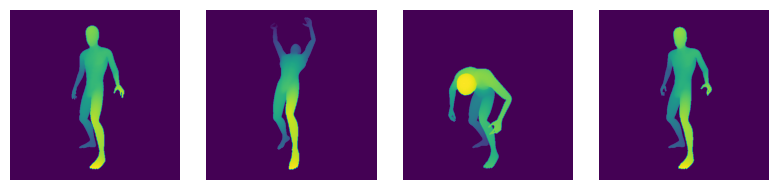

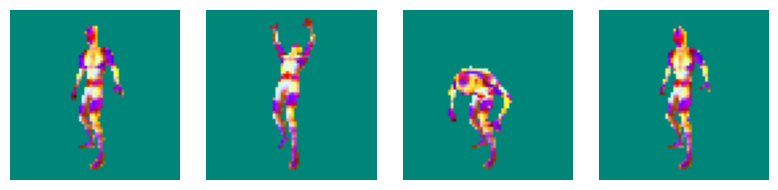

In [13]:
from einops import rearrange
from omegaconf import OmegaConf
from text3d2video.ipython_utils import display_ims
from text3d2video.rendering import make_rasterizer, normalize_depth_map, rasterize_vertex_features
from text3d2video.util import front_camera, ordered_sample
from text3d2video.visualization import RgbPcaUtil
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF

cfg = OmegaConf.create({})
cfg.seed = 0
cfg.batch_size = 4
cfg.prompt = 'Deadpool'
cfg.frame_indices = ordered_sample(animation.frame_nums(), cfg.batch_size)
cfg.out_resolution = 512

camera = front_camera()

frames = animation.load_frames(cfg.frame_indices)

rasterizer = make_rasterizer(camera, cfg.out_resolution)
fragments = rasterizer(frames)
depth_maps = normalize_depth_map(fragments.zbuf)
depth_maps  = [TF.to_pil_image(depth_map[:, :, 0]) for depth_map in depth_maps]

display_ims(depth_maps, scale=2)

rendered_features = torch.stack([
    rasterize_vertex_features(camera, frame, feature_resolution, vert_features)
    for frame in frames
])

all_features = rearrange(rendered_features, 'b c h w -> (b h w) c')
pca = RgbPcaUtil(all_features.shape[1])
pca.fit(all_features.cpu())
pca_maps = [pca.feature_map_to_rgb_pil(map.cpu()) for map in rendered_features]

display_ims(pca_maps, scale=2)